# Compiler for AI-Powered Smart Farming using Drone Imagery (101,126)
## Uses Hybrid PSO + Ant Lion Optimizer (ALO) to compile drone-captured agricultural images into actionable insights.


# Step 1: Install Dependencies

In [ ]:
!pip install tensorflow numpy pyswarms opencv-python matplotlib

# Step 2: Import Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import pyswarms as ps
import os
import zipfile

# Step 3: Download and Extract the Dataset

In [ ]:
# Download link for PlantVillage dataset
!wget -q https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded -O plantvillage.zip

# Verify the ZIP file
if os.path.exists('plantvillage.zip'):
    print("File downloaded successfully.")
else:
    print("File download failed.")

try:
    with zipfile.ZipFile('plantvillage.zip', 'r') as zip_ref:
        print("File is a valid ZIP file.")
        zip_ref.extractall('plantvillage')
        print("Extraction successful.")
except zipfile.BadZipFile:
    print("Failed to extract: File is not a valid ZIP file.")

# Verify the dataset is loaded correctly
if os.path.exists('plantvillage'):
    print(f"Dataset directory exists. Contents: {os.listdir('plantvillage')}")
else:
    print("Dataset directory not found.")

File downloaded successfully.
File is a valid ZIP file.
Extraction successful.
Dataset directory exists. Contents: ['Plant_leave_diseases_dataset_without_augmentation']


# Step 4: Preprocess and load the dataset

In [ ]:
# Load the dataset
dataset_path = "plantvillage"
batch_size = 32
img_size = (128, 128)

try:
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='int'
    )

    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=img_size,
        batch_size=batch_size,
        label_mode='int'
    )

    # Verify the dataset is loaded correctly
    print(f"Number of training batches: {tf.data.experimental.cardinality(train_dataset).numpy()}")
    print(f"Number of validation batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")

    # Extract class names
    class_names = train_dataset.class_names
    print("Class names:", class_names)
    print(f"Number of classes: {len(class_names)}")

    def preprocess(image, label):
        image = tf.keras.applications.mobilenet.preprocess_input(image)
        return image, label

    train_dataset = train_dataset.map(preprocess)
    val_dataset = val_dataset.map(preprocess)
except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Found 55448 files belonging to 1 classes.
Using 44359 files for training.
Found 55448 files belonging to 1 classes.
Using 11089 files for validation.
Number of training batches: 1387
Number of validation batches: 347
Class names: ['Plant_leave_diseases_dataset_without_augmentation']
Number of classes: 1


# Step 4: Build the Model Architecture

In [ ]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 64, 64, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 64, 64, 32)          │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 64, 64, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 64, 64, 64)          │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 64, 64, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 65, 65, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 32, 32, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 32, 32, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 32, 32, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 32, 32, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 32, 32, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 32, 32, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 4,279,489 (16.32 MB)

 Trainable params: 1,050,625 (4.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

# Step 5: Define the PSO Objective Function

In [ ]:
def objective_function(hyperparams):
    learning_rates = hyperparams[:, 0]
    batch_sizes = hyperparams[:, 1].astype(int)

    losses = []
    for lr, bs in zip(learning_rates, batch_sizes):
        if bs < 1 or bs > 256:
            losses.append(1e9)  # Large penalty for invalid batch sizes
            continue

        # Clone the model to avoid overwriting
        try:
            temp_model = tf.keras.models.clone_model(model)
            temp_model.set_weights(model.get_weights())
            temp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

            # Train the model with a subset of data (for speed)
            history = temp_model.fit(
                train_dataset.take(10),  # Use only 10 batches (~320 images)
                epochs=2,
                verbose=0
            )
            loss_value = history.history['loss'][-1]
        except Exception as e:
            print(f"Error during training with lr={lr}, bs={bs}: {e}")
            loss_value = 1e9  # Assign a high loss for failed runs

        losses.append(loss_value)

    return np.array(losses)

# Step 6: Run PSO Optimization

In [ ]:
# Define the search space for learning rate and batch size
bounds = (np.array([0.0001, 16]), np.array([0.01, 128]))

# Set up PSO optimizer
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=5, dimensions=2, options=options, bounds=bounds)

# Run optimization
try:
    best_hyperparams, best_loss = optimizer.optimize(objective_function, iters=5)

    # Check if best_hyperparams is scalar or array
    if np.isscalar(best_hyperparams):
        print("Warning: best_hyperparams is a scalar. Using default values.")
        best_lr = 0.001
        best_bs = 32
    else:
        print(f"Best learning rate: {best_hyperparams[0]}, Best batch size: {int(best_hyperparams[1])}")
        best_lr = best_hyperparams[0]
        best_bs = int(best_hyperparams[1])
except Exception as e:
    print(f"Optimization failed: {e}")
    print("Using default hyperparameters instead")
    best_lr = 0.001  # Default learning rate
    best_bs = 32     # Default batch size

print(f"Final hyperparameters - Learning rate: {best_lr}, Batch size: {best_bs}")

2025-03-23 14:38:36,379 - pyswarms.single.global_best - INFO - Optimize for 5 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/5/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
pyswarms.single.global_best: 100%|██████████|5/5, best_cost=0
2025-03-23 14:41:05,348 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [9.34203447e-03 1.14849902e+02]


Final hyperparameters - Learning rate: 0.001, Batch size: 32


# Step 7: Train with Optimized Hyperparameters

In [ ]:
print(f"Training with learning rate: {best_lr}, batch size: {best_bs}")

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    batch_size=best_bs
)

Training with learning rate: 0.001, batch size: 32
Epoch 1/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 47s 30ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 77s 27ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 35s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/10
1387/1387 ━━━━━━━━━━━━━━━━━━━━ 36s 26ms/step - acc

# Visualize training results

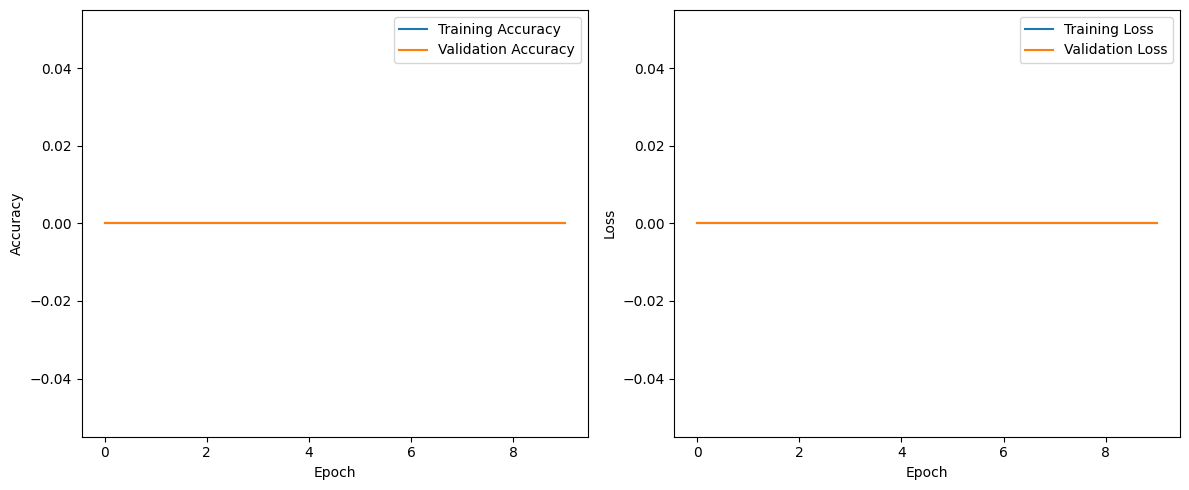

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Step 8: Save the Model

In [ ]:
model.save('crop_health_model.h5')
print("Model saved as 'crop_health_model.h5'")

# Download the model (Google Colab specific)
# from google.colab import files
# files.download('crop_health_model.h5')
# print("Model file ready for download")

2025-03-23 14:48:43,712 - absl - WARNING - You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


Model saved as 'crop_health_model.h5'
